In [3]:
import os
import json
import pandas as pd
from datetime import datetime

# If in Colab:
from google.colab import files

from openai import OpenAI


In [6]:
OPENAI_API_KEY = ("")
MODEL_NAME = "gpt-5.1"
RANDOM_SEED = 42

client = OpenAI(api_key=OPENAI_API_KEY)

print("OpenAI client initialized!")
print("Model:", MODEL_NAME)


OpenAI client initialized!
Model: gpt-5.1


Upload Phase 1 output CSV (heart_disease_freetext_step1_generated.csv)


Saving heart_disease_freetext_step1_generated.csv to heart_disease_freetext_step1_generated.csv
Upload Original dataset CSV (Heart_Disease.csv)


Saving Heart_Disease.csv to Heart_Disease.csv
Phase 1 file: heart_disease_freetext_step1_generated.csv
Original file: Heart_Disease.csv


In [6]:
SEX_MAP = {0: "female", 1: "male"}
CHEST_PAIN_MAP = {0: "typical angina", 1: "atypical angina", 2: "non-anginal pain", 3: "asymptomatic"}
FASTING_BLOOD_SUGAR_MAP = {0: "normal", 1: "elevated"}
RESTING_ECG_MAP = {0: "normal ECG", 1: "ST-T wave abnormality", 2: "left ventricular hypertrophy"}
EXERCISE_ANGINA_MAP = {0: "No", 1: "Yes"}
ST_SLOPE_MAP = {0: "upsloping", 1: "flat", 2: "downsloping"}

FIELDS = ["age", "sex", "chest_pain_type", "resting_bp", "cholesterol",
          "fasting_blood_sugar", "resting_ecg", "max_heart_rate",
          "exercise_angina", "oldpeak", "ST_slope"]


In [7]:
def step2_1_validate_and_correct(free_text, original_row):
    sex = SEX_MAP.get(int(original_row['sex']), str(original_row['sex']))
    chest_pain = CHEST_PAIN_MAP.get(int(original_row['chest pain type']), str(original_row['chest pain type']))
    fbs = FASTING_BLOOD_SUGAR_MAP.get(int(original_row['fasting blood sugar']), str(original_row['fasting blood sugar']))
    ecg = RESTING_ECG_MAP.get(int(original_row['resting ecg']), str(original_row['resting ecg']))
    exercise_angina = EXERCISE_ANGINA_MAP.get(int(original_row['exercise angina']), str(original_row['exercise angina']))
    st_slope = ST_SLOPE_MAP.get(int(original_row['ST slope']), str(original_row['ST slope']))

    validation_prompt = f"""
ORIGINAL PATIENT DATA (Ground Truth):
- Age: {original_row['age']} years
- Sex: {sex}
- Chest Pain Type: {chest_pain}
- Resting Blood Pressure: {original_row['resting bp s']} mm Hg
- Serum Cholesterol: {original_row['cholesterol']} mg/dL
- Fasting Blood Sugar: {fbs}
- Resting ECG: {ecg}
- Maximum Heart Rate Achieved: {original_row['max heart rate']} bpm
- Exercise-Induced Angina: {exercise_angina}
- ST Depression (Oldpeak): {original_row['oldpeak']}
- ST Slope at Peak Exercise: {st_slope}

GENERATED FREE-TEXT DESCRIPTION:
{free_text}
"""

    system_msg = """You are a medical data validator.

Compare the generated free-text description with the original patient data.
Check for missing values or contradictions.
If issues exist, correct the text so that ALL original data is reflected.
Keep the corrected text natural.

Return ONLY valid JSON:
{
  "has_issues": true/false,
  "issues_found": ["..."],
  "corrected_text": "..."
}
"""

    try:
        resp = client.responses.create(
            model=MODEL_NAME,
            input=[
                {"role": "system", "content": system_msg},
                {"role": "user", "content": validation_prompt},
            ],
            max_output_tokens=800,
            temperature=0
        )

        result = resp.output_text.strip()

        # If model wraps JSON in ```json ... ```
        if result.startswith("```"):
            result = result.split("```")[1]
            if result.lstrip().startswith("json"):
                result = result.lstrip()[4:]
            result = result.strip()

        return json.loads(result)

    except Exception as e:
        print(f"  [Step 2.1] API/JSON error: {e}")
        return {"has_issues": False, "issues_found": [], "corrected_text": free_text}


In [8]:
def step2_2_reverse_map(corrected_text):
    system_msg = """You are a medical data extractor.

Given ONLY a clinical free-text description, extract clinical values.

Mappings:
- sex: female=0, male=1
- chest pain type: typical angina=0, atypical angina=1, non-anginal pain=2, asymptomatic=3
- fasting blood sugar: normal/≤120=0, elevated/>120=1
- resting ecg: normal=0, ST-T wave abnormality=1, left ventricular hypertrophy=2
- exercise angina: No=0, Yes=1
- ST slope: upsloping=0, flat=1, downsloping=2

Return ONLY valid JSON:
{
  "age": <number>,
  "sex": <0 or 1>,
  "chest_pain_type": <0-3>,
  "resting_bp": <number>,
  "cholesterol": <number>,
  "fasting_blood_sugar": <0 or 1>,
  "resting_ecg": <0-2>,
  "max_heart_rate": <number>,
  "exercise_angina": <0 or 1>,
  "oldpeak": <number>,
  "ST_slope": <0-2>
}
"""

    try:
        resp = client.responses.create(
            model=MODEL_NAME,
            input=[
                {"role": "system", "content": system_msg},
                {"role": "user", "content": f"Extract clinical values from:\n\n{corrected_text}"},
            ],
            max_output_tokens=350,
            temperature=0
        )

        result = resp.output_text.strip()

        if result.startswith("```"):
            result = result.split("```")[1]
            if result.lstrip().startswith("json"):
                result = result.lstrip()[4:]
            result = result.strip()

        return json.loads(result)

    except Exception as e:
        print(f"  [Step 2.2] API/JSON error: {e}")
        return None


In [9]:
def compare_values(original_row, regenerated_values):
    if regenerated_values is None:
        return {"consistency_score": 0, "field_matches": {}, "total_matches": 0, "total_fields": len(FIELDS)}

    original_mapping = {
        "age": float(original_row['age']),
        "sex": int(original_row['sex']),
        "chest_pain_type": int(original_row['chest pain type']),
        "resting_bp": float(original_row['resting bp s']),
        "cholesterol": float(original_row['cholesterol']),
        "fasting_blood_sugar": int(original_row['fasting blood sugar']),
        "resting_ecg": int(original_row['resting ecg']),
        "max_heart_rate": float(original_row['max heart rate']),
        "exercise_angina": int(original_row['exercise angina']),
        "oldpeak": float(original_row['oldpeak']),
        "ST_slope": int(original_row['ST slope'])
    }

    total_matches = 0
    field_matches = {}

    for field in FIELDS:
        original_val = original_mapping.get(field)
        regen_val = regenerated_values.get(field)

        if original_val is not None and regen_val is not None:
            if isinstance(original_val, float) and isinstance(regen_val, (int, float)):
                match = abs(float(original_val) - float(regen_val)) < 0.5
            else:
                match = int(original_val) == int(regen_val)
        else:
            match = False

        field_matches[field] = {
            "original": original_val,
            "regenerated": regen_val,
            "match": match
        }
        if match:
            total_matches += 1

    consistency_score = (total_matches / len(FIELDS)) * 100

    return {
        "consistency_score": round(consistency_score, 2),
        "field_matches": field_matches,
        "total_matches": total_matches,
        "total_fields": len(FIELDS)
    }


In [10]:
def validate_dataset(input_file, original_data_file, output_prefix="output"):
    print(f"\n{'='*70}")
    print("FREE-TEXT VALIDATION PIPELINE (PHASE 2)")
    print("Using OpenAI model:", MODEL_NAME)
    print(f"{'='*70}")

    phase1_df = pd.read_csv(input_file)
    original_df = pd.read_csv(original_data_file)

    total_rows = min(len(phase1_df), len(original_df))
    print("Phase1:", phase1_df.shape, "Original:", original_df.shape)
    if len(phase1_df) != len(original_df):
        print("WARNING: Row count mismatch; using min rows:", total_rows)

    results = []
    for idx in range(total_rows):
        row = original_df.iloc[idx]
        feature_text = phase1_df.iloc[idx]["Feature"]
        free_text = phase1_df.iloc[idx]["Free_Text"]
        target = phase1_df.iloc[idx]["Target"]

        print(f"\n[Row {idx+1}/{total_rows}]")

        v = step2_1_validate_and_correct(free_text, row)
        corrected = v.get("corrected_text", free_text)

        regenerated = step2_2_reverse_map(corrected)
        comparison = compare_values(row, regenerated)

        print("Consistency:", comparison["consistency_score"], "%")

        results.append({
            "Feature": feature_text,
            "Free_Text": corrected,
            "Target": target,
            "consistency_score": comparison["consistency_score"],
            "had_issues": v.get("has_issues", False),
            "issues_found": v.get("issues_found", [])
        })

    final_df = pd.DataFrame(results)
    final_file = f"{output_prefix}_final.csv"
    final_df.to_csv(final_file, index=False)
    print("\nSaved:", final_file)

    return final_df


In [18]:
final_df = validate_dataset(phase1_output, original_data, output_prefix="heart_disease_freetext")
final_df.head()



FREE-TEXT VALIDATION PIPELINE (PHASE 2)
Using OpenAI model: gpt-5.1
Phase1: (1190, 3) Original: (1190, 12)

[Row 1/1190]
Consistency: 100.0 %

[Row 2/1190]
Consistency: 100.0 %

[Row 3/1190]
Consistency: 100.0 %

[Row 4/1190]
Consistency: 90.91 %

[Row 5/1190]
Consistency: 100.0 %

[Row 6/1190]
Consistency: 100.0 %

[Row 7/1190]
Consistency: 100.0 %

[Row 8/1190]
Consistency: 100.0 %

[Row 9/1190]
Consistency: 90.91 %

[Row 10/1190]
Consistency: 100.0 %

[Row 11/1190]
Consistency: 100.0 %

[Row 12/1190]
Consistency: 100.0 %

[Row 13/1190]
Consistency: 100.0 %

[Row 14/1190]
Consistency: 90.91 %

[Row 15/1190]
Consistency: 100.0 %

[Row 16/1190]
  [Step 2.1] API/JSON error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Consis

,Feature,Free_Text,Target,consistency_score,had_issues,issues_found
0,"age-40.0, sex-male, chest pain type-non-angina...",The patient is a 40-year-old male who presente...,No heart Disease,100.00,True,[The description labels a single resting blood...
1,"age-49.0, sex-female, chest pain type-asymptom...",The patient is a 49-year-old female who presen...,Heart Disease,100.00,False,[]
2,"age-37.0, sex-male, chest pain type-non-angina...",The patient is a 37-year-old male who presente...,No heart Disease,100.00,False,[]
3,"age-48.0, sex-female, chest pain type-asymptom...",The patient is a 48-year-old female with chest...,Heart Disease,90.91,True,[The generated text adds interpretive/clinical...
4,"age-54.0, sex-male, chest pain type-asymptomat...",The patient is a 54-year-old male who presente...,No heart Disease,100.00,True,[The statement that the achieved maximum heart...


In [19]:
# Overall average consistency
avg_consistency = final_df["consistency_score"].mean()
print(f"✅ Average Consistency: {avg_consistency:.2f}%")


✅ Average Consistency: 94.61%


In [20]:
total = len(final_df)
perfect = (final_df["consistency_score"] == 100).sum()
ge_90 = (final_df["consistency_score"] >= 90).sum()
lt_90 = (final_df["consistency_score"] < 90).sum()

summary_df = pd.DataFrame([{
    "total_rows": total,
    "avg_consistency_%": round(avg_consistency, 2),
    "perfect_100%": perfect,
    ">=90%": ge_90,
    "<90%": lt_90
}])

summary_df


,total_rows,avg_consistency_%,perfect_100%,>=90%,<90%
0,1190,94.61,539,1135,55


In [21]:
final_df[["Feature", "Target", "consistency_score"]].head(10)


,Feature,Target,consistency_score
0,"age-40.0, sex-male, chest pain type-non-angina...",No heart Disease,100.00
1,"age-49.0, sex-female, chest pain type-asymptom...",Heart Disease,100.00
2,"age-37.0, sex-male, chest pain type-non-angina...",No heart Disease,100.00
3,"age-48.0, sex-female, chest pain type-asymptom...",Heart Disease,90.91
4,"age-54.0, sex-male, chest pain type-asymptomat...",No heart Disease,100.00
5,"age-39.0, sex-male, chest pain type-asymptomat...",No heart Disease,100.00
6,"age-45.0, sex-female, chest pain type-non-angi...",No heart Disease,100.00
7,"age-54.0, sex-male, chest pain type-non-angina...",No heart Disease,100.00
8,"age-37.0, sex-male, chest pain type-asymptomat...",Heart Disease,90.91
9,"age-48.0, sex-female, chest pain type-non-angi...",No heart Disease,100.00


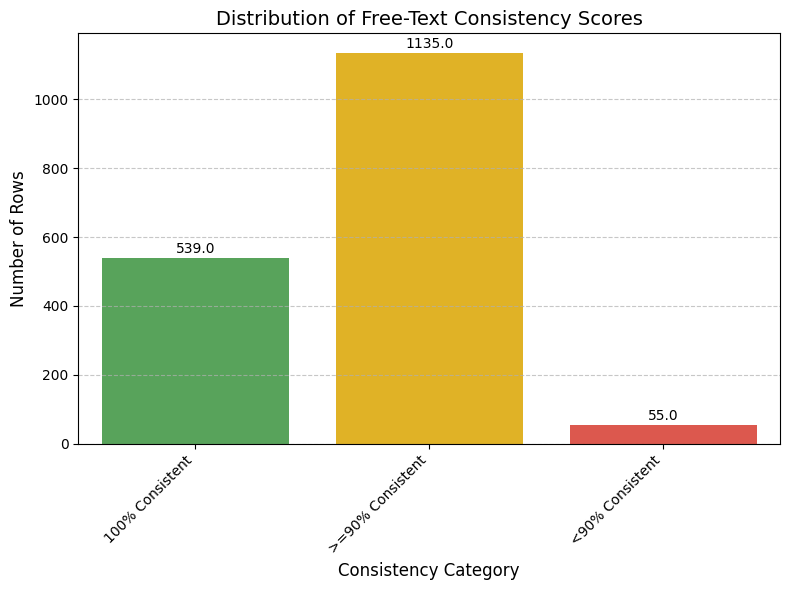

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

summary_data = summary_df.loc[0, ['perfect_100%', '>=90%', '<90%']]
labels = ['100% Consistent', '>=90% Consistent', '<90% Consistent']
colors = ['#4CAF50', '#FFC107', '#F44336']

# Prepare data for plotting with explicit categories for hue
plot_df = pd.DataFrame({
    'Consistency Category': labels,
    'Number of Rows': summary_data.values
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Consistency Category', y='Number of Rows', data=plot_df, palette=colors, hue='Consistency Category', legend=False)
plt.title('Distribution of Free-Text Consistency Scores', fontsize=14)
plt.xlabel('Consistency Category', fontsize=12)
plt.ylabel('Number of Rows', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for index, value in enumerate(summary_data):
    plt.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()